<a href="https://colab.research.google.com/github/Mahiyan-Khan-Abir/Projects_2022-2023/blob/main/text_to_imagegenertion_with_increased_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Necessary imports
import glob
import pandas as pd
import urllib.request
import imageio
import os
import numpy as np

from urllib.request import urlopen

In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install torch torchvision einops tqdm matplotlib numpy Pillow


In [ ]:
!pip install einops tqdm

In [ ]:
!pip install einops tqdm matplotlib torch torchvision

################

In [ ]:
# Load Glove Function
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r',encoding="utf8")
    model = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            model[word] = embedding
        except:
            print(word)
    print("Done.",len(model)," words loaded!")
    return model

In [ ]:
glove_embeddings = loadGloveModel("/content/drive/MyDrive/Thesis/glove.6B.300d.txt")

Loading Glove Model
Done. 400000  words loaded!


In [ ]:
# Setting up the paths
train_data_path = "/content/drive/MyDrive/Thesis/102flowers"
train_images_path = "/content/drive/MyDrive/Thesis/102flowers/jpg"
train_captions_path = "/content/drive/MyDrive/Thesis/102flowers/text_c10"

The following packages will be used to implement a basic GAN system in Python/Keras.

In [ ]:
# Imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Concatenate
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from sklearn.metrics import mean_squared_error

import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt

In [ ]:
# Formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
# Generation resolution - Must be square
# Training data is also scaled to this.
GENERATE_RES = 2 # Generation resolution factor
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100
EMBEDDING_SIZE = 300

# Configuration
DATA_PATH = train_images_path
MODEL_PATH = "/content/drive/MyDrive/Thesis/102flowers/model"
EPOCHS = 50
BATCH_SIZE = 64
BUFFER_SIZE = 4000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.


## Data Pre-Processing

Next we will load and preprocess the images.  This can take awhile.  Google CoLab took around an hour to process.  Because of this we store the processed file as a binary.  This way we can simply reload the processed training data and quickly use it.  It is most efficient to only perform this operation once.  The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change.

In [ ]:
# Image set has 8,188 images.  Can take over an hour
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.

training_binary_path = os.path.join("/content/drive/MyDrive/Thesis/102flowers/npy64",
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}_')

start = time.time()
print("Loading training images...")

training_data = []
flowers_path = sorted(os.listdir(DATA_PATH))

for filename in range(len(flowers_path)):
    path = os.path.join(DATA_PATH,flowers_path[filename])
    # print(path)
    try:
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      channel = np.asarray(image).shape[2]
      if channel == 3:
        training_data.append(np.asarray(image))
    except KeyboardInterrupt:
        print("Keyboard Interrup by me...")
        break
    except:
      pass
    if len(training_data) == 100:
      training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
                GENERATE_SQUARE,IMAGE_CHANNELS))
      training_data = training_data.astype(np.float32)
      #Normalizing the input
      training_data = training_data / 127.5 - 1.

      print("Saving training image " + str(100000 + filename) + ".npy")
      np.save(training_binary_path + str(100000 + filename) + ".npy",training_data)
      elapsed = time.time()-start
      print (f'Image preprocess time: {hms_string(elapsed)}')
      training_data = []
print("Complete")

Loading training images...
Saving training image 100099.npy
Image preprocess time: 0:01:03.71
Saving training image 100199.npy
Image preprocess time: 0:02:09.42
Saving training image 100299.npy
Image preprocess time: 0:03:12.96
Saving training image 100399.npy
Image preprocess time: 0:04:21.10
Saving training image 100499.npy
Image preprocess time: 0:05:25.98
Saving training image 100599.npy
Image preprocess time: 0:06:31.56
Saving training image 100699.npy
Image preprocess time: 0:07:38.62
Saving training image 100799.npy
Image preprocess time: 0:08:42.61
Saving training image 100899.npy
Image preprocess time: 0:09:48.97
Saving training image 100999.npy
Image preprocess time: 0:10:52.36
Saving training image 101099.npy
Image preprocess time: 0:12:02.87
Saving training image 101199.npy
Image preprocess time: 0:13:10.82
Saving training image 101299.npy
Image preprocess time: 0:14:14.24
Saving training image 101399.npy
Image preprocess time: 0:15:17.00
Saving training image 101499.npy
Im

Next we will load and preprocess the captions. This can take awhile. Google CoLab took around an hour to process. Because of this we store the processed file as a binary. This way we can simply reload the processed data and quickly use it. It is most efficient to only perform this operation once.

In [ ]:
text_path = "/content/drive/Shareddrives/D4NLP Project/flowers data/flowers/text_c10/captions"
text_files = sorted(os.listdir(text_path))
captions = []
caption_embeddings = np.zeros((len(text_files),300),dtype=np.float32)
for filename in range(len(text_files)):
    path = os.path.join(text_path,text_files[filename])
    # print(path)
    f = open(path,'r')
    data = f.read()
    data = data.split("\n")
    f.close()
    for d in range(1):
      x = data[d].lower()
      x = x.replace(" ","")
      captions.append(x)
      count = 0
      for t in x:
        try:
          caption_embeddings[filename] += glove_embeddings[t]
          count += 1
        except:
          print(t)
          pass
      caption_embeddings[filename] /= count
    if filename %100 == 0:
      print("-------------Files completed:",filename)

In [ ]:
# saving the caption embeddings numpy
embedding_binary_path = os.path.join('/content/drive/MyDrive/Thesis/102flowers/embedding_npy',
        f'embedding_data_character.npy')
# print("Saving captions embeddings binary...")
# np.save(embedding_binary_path,caption_embeddings)

In [ ]:
# saving the caption embeddings numpy
embedding_binary_path = os.path.join('/content/drive/MyDrive/Thesis/102flowers/embedding_npy',
        f'embedding_data.npy')
print("Saving captions embeddings binary...")
np.save(embedding_binary_path,caption_embeddings)

In [ ]:
# Creating a dataframe to store the captions
df_captions = pd.DataFrame([])
df_captions['captions'] = captions[:len(final_images)]

In [ ]:
df_captions.head()

,captions
0,"prominent purple stigma , petals are white inc..."
1,"this flower has bright purple , spiky petals ..."
2,this flower has a row of white petals with the...
3,"this flower is white and blue in color , with..."
4,this flower has petals that are green with str...


In [ ]:
captions[:10]

['prominent purple stigma , petals are white inc olor',
 'this flower has bright purple ,  spiky petals ,  and greenish sepals below them . ',
 'this flower has a row of white petals with the multi - colored stamens and a pistil at the centre',
 'this flower is white and blue in color ,  with petals that are oval shaped . ',
 'this flower has petals that are green with stringy purple stamen',
 'this flower is blue and green in color ,  with petals that are oval shaped . ',
 'the petals of the flower are bright blue with white lines ,  and the stamen is bright green with black dots . ',
 'the flower has stamen and the petals are green in color . ',
 'this flower has green petals and purple and green stamen . ',
 'the flower shown has green pollen tubes with green sepal and blue petals']

In [ ]:
df_captions.to_csv("/content/drive/MyDrive/Thesis/102flowers/text_c10",index=None)

## Loading and combining numpys

In [ ]:
embedding_binary_path = os.path.join('/content/drive/MyDrive/Thesis/102flowers/embedding_npy',
        f'embedding_data.npy')

In [ ]:
caption_embeddings = np.load(embedding_binary_path)

In [ ]:
caption_embeddings.shape

(8189, 300)

In [ ]:
caption_embeddings = caption_embeddings[::5]

In [ ]:
caption_embeddings.shape

(8188, 300)

In [ ]:
image_binary_path = "/content/drive/MyDrive/Thesis/102flowers/npy64"
images = os.listdir(image_binary_path)

In [ ]:
images[-1]

'training_data_64_64_108099.npy'

In [ ]:
# Creating a list of all the preprocessed images
final_images = np.load(image_binary_path + images[0])
for i in images[1:]:
  print(i)
  try:
    final_images = np.concatenate([final_images,np.load(image_binary_path + i)],axis = 0)
  except:
    pass

training_data_64_64_100199.npy
training_data_64_64_100299.npy
training_data_64_64_100399.npy
training_data_64_64_100499.npy
training_data_64_64_100599.npy
training_data_64_64_100699.npy
training_data_64_64_100799.npy
training_data_64_64_100899.npy
training_data_64_64_100999.npy
training_data_64_64_101099.npy
training_data_64_64_101199.npy
training_data_64_64_101299.npy
training_data_64_64_101399.npy
training_data_64_64_101499.npy
training_data_64_64_101599.npy
training_data_64_64_101699.npy
training_data_64_64_101799.npy
training_data_64_64_101899.npy
training_data_64_64_101999.npy
training_data_64_64_102099.npy
training_data_64_64_102199.npy
training_data_64_64_102299.npy
training_data_64_64_102399.npy
training_data_64_64_102499.npy
training_data_64_64_102599.npy
training_data_64_64_102699.npy
training_data_64_64_102799.npy
training_data_64_64_102899.npy
training_data_64_64_102999.npy
training_data_64_64_103099.npy
training_data_64_64_103199.npy
training_data_64_64_103299.npy
training

In [ ]:
final_images.shape

(8100, 64, 64, 3)

In [ ]:
df_captions = pd.read_csv("/content/drive/MyDrive/Thesis/102flowers/text_c10/captions.csv")

In [ ]:
df_captions.head()

,captions
0,"prominent purple stigma , petals are white inc..."
1,"this flower has bright purple , spiky petals ..."
2,this flower has a row of white petals with the...
3,"this flower is white and blue in color , with..."
4,this flower has petals that are green with str...


In [ ]:
captions = list(df_captions.captions[::5])

In [ ]:
len(captions)

8100

Saved images separately for testing

In [ ]:
save_images_captions = captions[:28].copy()
save_images_embeddings = np.copy(caption_embeddings[:28])
save_images_npy = np.copy(final_images[:28])

In [ ]:
caption_embeddings = caption_embeddings[:final_images.shape[0]]

In [ ]:
caption_embeddings.shape

(8100, 300)

Shuffling the data

In [ ]:
p = np.random.permutation(len(final_images))

In [ ]:
final_images_shuffled = final_images[p]
final_embeddings_shuffled = caption_embeddings[p]

In [ ]:
final_images_shuffled.shape

(8100, 64, 64, 3)

In [ ]:
final_embeddings_shuffled.shape

(8100, 300)

In [ ]:
# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
#     .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices({'images': final_images,
                                                    'embeddings': caption_embeddings}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Data Modeling

Defining the Generator and Discriminator

In [ ]:
def build_generator_func(seed_size,embedding_size, channels):
  input_seed = Input(shape=seed_size)
  input_embed = Input(shape = embedding_size)
  d0 = Dense(128)(input_embed)
  leaky0 = LeakyReLU(alpha=0.2)(d0)

  merge = Concatenate()([input_seed, leaky0])

  d1 = Dense(4*4*256,activation="relu")(merge)
  reshape = Reshape((4,4,256))(d1)

  upSamp1 = UpSampling2D()(reshape)
  conv2d1 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp1)
  batchNorm1 = BatchNormalization(momentum=0.8)(conv2d1)
  leaky1 = LeakyReLU(alpha=0.2)(batchNorm1)

  upSamp2 = UpSampling2D()(leaky1)
  conv2d2 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  upSamp3 = UpSampling2D()(leaky2)
  conv2d3 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  upSamp4 = UpSampling2D(size=(GENERATE_RES,GENERATE_RES))(leaky3)
  conv2d4 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  outputConv = Conv2DTranspose(channels,kernel_size=3,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(leaky4)
  outputActi = Activation("tanh")(outputConv)

  model = Model(inputs=[input_seed,input_embed], outputs=outputActi)
  return model

def build_discriminator_func(image_shape, embedding_size):
  input_shape = Input(shape=image_shape)
  input_embed = Input(shape=embedding_size)

  conv2d1 = Conv2D(32,kernel_size=4,strides=2,input_shape=image_shape,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_shape)
  leaky1 = LeakyReLU(alpha=0.2)(conv2d1)

  drop2 = Dropout(0.25)(leaky1)
  conv2d2 = Conv2D(64, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop2)
  # zero2 = ZeroPadding2D(padding=((0,1),(0,1)))(conv2d2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  drop3 = Dropout(0.25)(leaky2)
  conv2d3 = Conv2D(128, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  drop4 = Dropout(0.25)(leaky3)
  conv2d4 = Conv2D(256, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  dense_embed = Dense(128,kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_embed)
  leaky_embed = LeakyReLU(alpha=0.2)(dense_embed)
  reshape_embed = Reshape((4,4,8))(leaky_embed)
  merge_embed = Concatenate()([leaky4, reshape_embed])

  drop5 = Dropout(0.25)(merge_embed)
  conv2d5 = Conv2D(512, kernel_size=4,kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop5)
  batchNorm5 = BatchNormalization(momentum=0.8)(conv2d5)
  leaky5 = LeakyReLU(alpha=0.2)(batchNorm5)

  drop6 = Dropout(0.25)(leaky5)
  flatten = Flatten()(drop6)
  output = Dense(1,activation="sigmoid")(flatten)

  model = Model(inputs=[input_shape,input_embed], outputs=output)
  return model

Function to save image samples generated

In [ ]:
def save_images(cnt,noise,embeds):
  image_array = np.full((
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3),
      255, dtype=np.uint8)

  generated_images = generator.predict((noise,embeds))

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1


  output_path = "/content/drive/Shareddrives/D4NLP Project/flowers data/flowers/output_64_character_extended"
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [ ]:
# Initlializing a generator
generator = build_generator_func(SEED_SIZE,EMBEDDING_SIZE, IMAGE_CHANNELS)
generator.load_weights("/content/drive/MyDrive/Thesis/102flowers/model/text_to_image_generator_cub_character.h5")

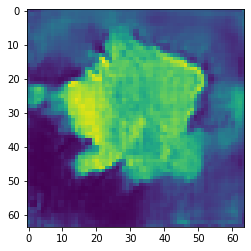

In [ ]:
# Sample output from the Generator
noise = tf.random.normal([1, 100])
generated_image = generator((noise,caption_embeddings[5].reshape(1,300)), training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
# Initlializing a discriminator
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator_func(image_shape,EMBEDDING_SIZE)
discriminator.load_weights((os.path.join(MODEL_PATH,"text_to_image_disc_cub_character.h5")))

In [ ]:
decision = discriminator((generated_image,caption_embeddings[5].reshape(1,300)))
print(decision)

tf.Tensor([[0.2522805]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text):
    real_loss = cross_entropy(tf.random.uniform(real_image_real_text.shape,0.8,1.0), real_image_real_text)
    fake_loss = (cross_entropy(tf.random.uniform(fake_image_real_text.shape,0.0,0.2), fake_image_real_text) +
                 cross_entropy(tf.random.uniform(real_image_fake_text.shape,0.0,0.2), real_image_fake_text))/2

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)

## Training

In [ ]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,captions,fake_captions):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE],dtype=tf.float32)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator((seed,captions), training=True)
    real_image_real_text = discriminator((images,captions), training=True)
    real_image_fake_text = discriminator((images,fake_captions), training=True)
    fake_image_real_text = discriminator((generated_images,captions), training=True)

    gen_loss = generator_loss(fake_image_real_text)
    disc_loss = discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text)
    # print(gen_loss)
    # print(disc_loss)

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
# Function that executes trianing process
def train(train_dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  fixed_embed = save_images_embeddings

  start = time.time()

  for epoch in range(epochs):
    print("epoch start...")
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for batch in train_dataset[:-1]:
      # train_batch = training_data[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
      # caption_batch = captions[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
      train_batch = batch['images']
      caption_batch = batch['embeddings']

      fake_caption_batch = np.copy(caption_batch)
      np.random.shuffle(fake_caption_batch)

      t = train_step(train_batch,caption_batch,fake_caption_batch)
      # print(t)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
      # if image_batch%50 == 0:
      #   print(image_batch)
      # print("here")
    print("now")
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed,fixed_embed)

    generator.save(os.path.join(MODEL_PATH,"text_to_image_generator_cub_character.h5"))
    discriminator.save(os.path.join(MODEL_PATH,"text_to_image_disc_cub_character.h5"))
    print("model saved")

  elapsed = time.time()-start
  print ('Training time:', hms_string(elapsed))


In [ ]:
train(list(train_dataset.as_numpy_iterator()), 500)

epoch start...
now
Epoch 1, gen loss=0.7686348557472229,disc loss=1.5495121479034424, 0:00:16.03
model saved
epoch start...
now
Epoch 2, gen loss=0.7586959600448608,disc loss=1.4737610816955566, 0:00:13.88
model saved
epoch start...
now
Epoch 3, gen loss=0.7599285840988159,disc loss=1.4424796104431152, 0:00:13.88
model saved
epoch start...
now
Epoch 4, gen loss=0.7321832776069641,disc loss=1.4321304559707642, 0:00:13.89
model saved
epoch start...
now
Epoch 5, gen loss=0.7370102405548096,disc loss=1.4232256412506104, 0:00:13.90
model saved
epoch start...
now
Epoch 6, gen loss=0.7280808091163635,disc loss=1.4163377285003662, 0:00:13.89
model saved
epoch start...
now
Epoch 7, gen loss=0.7229128479957581,disc loss=1.4120633602142334, 0:00:13.89
model saved
epoch start...
now
Epoch 8, gen loss=0.726793110370636,disc loss=1.4074561595916748, 0:00:13.89
model saved
epoch start...
now
Epoch 9, gen loss=0.719771683216095,disc loss=1.4027323722839355, 0:00:13.89
model saved
epoch start...
now
Ep

## Results

In [ ]:
save_images_embeddings.shape

(28, 300)

In [ ]:
# Printing the captions
save_images_captions

['prominent purple stigma , petals are white inc olor',
 'this flower is blue and green in color ,  with petals that are oval shaped . ',
 'outer petals are green in color and klarger , inner petals are needle shaped',
 'there are several shapes ,  sizes ,  and colors of petals on this complex flower . ',
 'the stamen are towering over the stigma which cannot be seen . ',
 'this flower is white and purple in color ,  with petals that are oval shaped . ',
 'the petals of this flower are green with a long stigma',
 'the blossom has a layer of rounded purple and white petals topped by a layer of fringed purple petals . ',
 'this flower is purple and yellow in color ,  with petals that are oval shaped . ',
 'the petals on this flower are white with an elaborate pistil . ',
 'this flower has petals that are pink with stringy white stamen',
 'this flower has star shaped white petals as its main feature . ',
 'lower petals are white in color , and larger in size , inner petals are purple in c

In [ ]:
def test_image(text,num):
  test_embeddings = np.zeros((1,300),dtype=np.float32)

  x = text.lower()
  x = x.replace(" ","")
  count = 0
  for t in x:
    try:
      test_embeddings[0] += glove_embeddings[t]
      count += 1
    except:
      print(t)
      pass
  test_embeddings[0] /= count
  test_embeddings =  np.repeat(test_embeddings,[28],axis=0)
  noise = tf.random.normal([28, 100])
  save_images(num,noise,test_embeddings)

In [ ]:
test_image("this flower is purple in color with oval shaped petals",1)

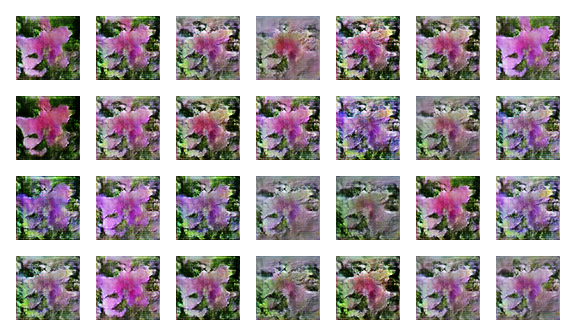

In [ ]:
import IPython
IPython.display.Image('/content/drive/MyDrive/Thesis/102flowers/output_64_character_extended/train-1.png')

In [ ]:
test_image("this flower is yellow in color with oval shaped petals",2)

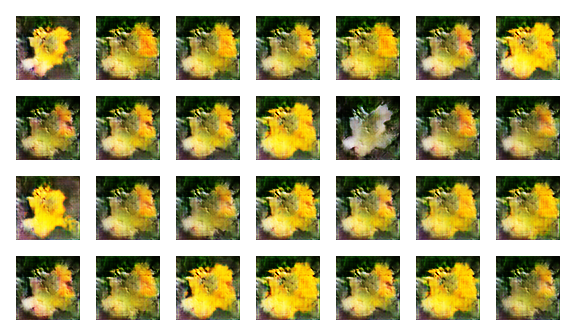

In [ ]:
import IPython
IPython.display.Image('/content/drive/MyDrive/Thesis/102flowers/output_64_character_extended/train-2.png')

In [ ]:
test_image("this flower is pink in color with oval shaped petals",3)

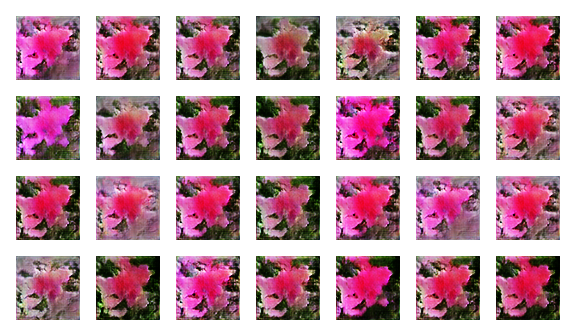

In [ ]:
import IPython
IPython.display.Image('/content/drive/Shareddrives/D4NLP Project/flowers data/flowers/output_64_character_extended/train-3.png')

In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(original, compressed):
    if original is None or compressed is None:
        raise ValueError("Error: Image not read properly.")

    # Resize the compressed image to match the shape of the original image
    compressed = cv2.resize(compressed, (original.shape[1], original.shape[0]))

    # Convert the images to grayscale
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    compressed_gray = cv2.cvtColor(compressed, cv2.COLOR_BGR2GRAY)

    mse = np.mean((original_gray - compressed_gray) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                 # Therefore PSNR has no importance.
        return 100
    max_pixel = 254.0  # Change this value to 1.0 for images with pixel values in the range [0, 1]
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def main():
    original_path = "/content/grid_image.png"
    compressed_path = "/content/Train_Examples.png"

    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    compressed = cv2.imread(compressed_path, cv2.IMREAD_UNCHANGED)

    try:
        value = PSNR(original, compressed)
        print(f"PSNR value is {value} dB")
    except ValueError as e:
        print(e)

if __name__ == "__main__":
    main()
#PSNR value more than 30 considered to be good. It means the similerities between the input and the generated image.

Error: Image not read properly.


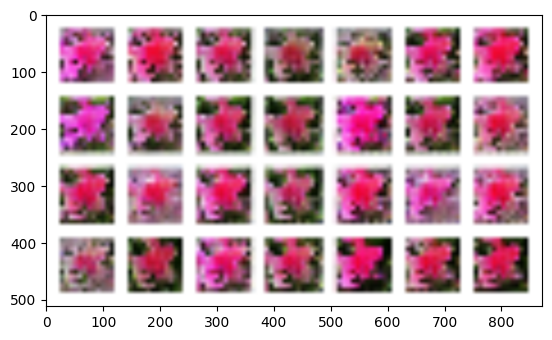

In [ ]:
#low res
plt.imshow(np.transpose(torchvision.utils.make_grid(LR_imgs[:4], padding=1, normalize=True).cpu(),(1,2,0)))

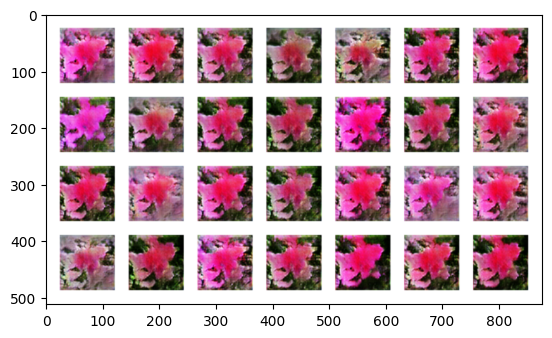

In [ ]:
#High res
plt.imshow(np.transpose(torchvision.utils.make_grid(imgs[:4], padding=1, normalize=True).cpu(),(1,2,0)))

Here starts Diffusion model SR3

In [ ]:
import torch, torchvision
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from einops import rearrange, repeat
from tqdm.notebook import tqdm
from functools import partial
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math, os, copy
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):

        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype, device=noise_level.device) / count
        encoding = noise_level.unsqueeze(1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat([torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding

class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(nn.Linear(in_channels, out_channels*(1+self.use_affine_level)))

    def forward(self, x, noise_embed):
        noise = self.noise_func(noise_embed).view(x.shape[0], -1, 1, 1)
        if self.use_affine_level:
            gamma, beta = noise.chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + noise
        return x

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))

class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)

# Linear Multi-head Self-attention
class SelfAtt(nn.Module):
    def __init__(self, channel_dim, num_heads, norm_groups=32):
        super(SelfAtt,self).__init__()
        self.groupnorm = nn.GroupNorm(norm_groups, channel_dim)
        self.num_heads = num_heads
        self.qkv = nn.Conv2d(channel_dim, channel_dim * 3, 1, bias=False)
        self.proj = nn.Conv2d(channel_dim, channel_dim, 1)

    def forward(self,x):
        b, c, h, w = x.size()
        x = self.groupnorm(x)
        qkv = rearrange(self.qkv(x), "b (qkv heads c) h w -> (qkv) b heads c (h w)", heads=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]

        keys = F.softmax(keys, dim=-1)
        att = torch.einsum('bhdn,bhen->bhde', keys, values)
        out = torch.einsum('bhde,bhdn->bhen', att, queries)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.num_heads, h=h, w=w)

        return self.proj(out)


class ResBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0,
                    num_heads=1, use_affine_level=False, norm_groups=32, att=True):
        super().__init__()
        self.noise_func = FeatureWiseAffine(noise_level_emb_dim, dim_out, use_affine_level)
        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
        self.att = att
        self.attn = SelfAtt(dim_out, num_heads=num_heads, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        y = self.block1(x)
        y = self.noise_func(y, time_emb)
        y = self.block2(y)
        x = y + self.res_conv(x)
        if self.att:
            x = self.attn(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channel=6, out_channel=3, inner_channel=64, norm_groups=64, #the input resolution has been set to be 32 her. The SR3 model takes the 32 and made it 128
        channel_mults=[1, 2, 4, 8, 8], res_blocks=3, dropout=0, img_size=512):
        super().__init__()  #the resolution has been set to be 256 here___^

        noise_level_channel = inner_channel
        self.noise_level_mlp = nn.Sequential(
            PositionalEncoding(inner_channel),
            nn.Linear(inner_channel, inner_channel * 4),
            Swish(),
            nn.Linear(inner_channel * 4, inner_channel)
        )

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = img_size

        # Downsampling stage of U-net
        downs = [nn.Conv2d(in_channel, inner_channel, kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResBlock(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel,
                    norm_groups=norm_groups, dropout=dropout))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResBlock(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel,
                            norm_groups=norm_groups, dropout=dropout),
            ResBlock(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel,
                        norm_groups=norm_groups, dropout=dropout, att=False)
        ])

        # Upsampling stage of U-net
        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResBlock(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel,
                    norm_groups=norm_groups, dropout=dropout))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, out_channel, groups=norm_groups)

    def forward(self, x, noise_level):
        # Embedding of time step with noise coefficient alpha
        t = self.noise_level_mlp(noise_level)

        feats = []
        for layer in self.downs:
            if isinstance(layer, ResBlock):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            x = layer(x, t)

        for layer in self.ups:
            if isinstance(layer, ResBlock):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)


"""
    Define Diffusion process framework to train desired model:
    Forward Diffusion process:
        Given original image x_0, apply Gaussian noise ε_t for each time step t
        After proper length of time step, image x_T reachs to pure Gaussian noise
    Objective of model f :
        model f is trained to predict actual added noise ε_t for each time step t
"""

class Diffusion(nn.Module):
    def __init__(self, model, device, img_size, LR_size, channels=3):
        super().__init__()
        self.channels = channels
        self.model = model.to(device)
        self.img_size = img_size
        self.LR_size = LR_size
        self.device = device

    def set_loss(self, loss_type):
        if loss_type == 'l1':
            self.loss_func = nn.L1Loss(reduction='sum')
        elif loss_type == 'l2':
            self.loss_func = nn.MSELoss(reduction='sum')
        else:
            raise NotImplementedError()

    def make_beta_schedule(self, schedule, n_timestep, linear_start=1e-4, linear_end=2e-2):
        if schedule == 'linear':
            betas = np.linspace(linear_start, linear_end, n_timestep, dtype=np.float64)
        elif schedule == 'warmup':
            warmup_frac=0.1
            betas = linear_end * np.ones(n_timestep, dtype=np.float64)
            warmup_time = int(n_timestep * warmup_frac)
            betas[:warmup_time] = np.linspace(linear_start, linear_end, warmup_time, dtype=np.float64)
        elif schedule == "cosine":
            cosine_s = 8e-3
            timesteps = torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep + cosine_s
            alphas = timesteps / (1 + cosine_s) * math.pi / 2
            alphas = torch.cos(alphas).pow(2)
            alphas = alphas / alphas[0]
            betas = 1 - alphas[1:] / alphas[:-1]
            betas = betas.clamp(max=0.999)
        else:
            raise NotImplementedError(schedule)
        return betas

    def set_new_noise_schedule(self, schedule_opt):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=self.device)

        betas = self.make_beta_schedule(
            schedule=schedule_opt['schedule'],
            n_timestep=schedule_opt['n_timestep'],
            linear_start=schedule_opt['linear_start'],
            linear_end=schedule_opt['linear_end'])
        betas = betas.detach().cpu().numpy() if isinstance(betas, torch.Tensor) else betas
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
        self.sqrt_alphas_cumprod_prev = np.sqrt(np.append(1., alphas_cumprod))

        self.num_timesteps = int(len(betas))
        # Coefficient for forward diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(alphas_cumprod_prev))
        self.register_buffer('pred_coef1', to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('pred_coef2', to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # Coefficient for reverse diffusion posterior q(x_{t-1} | x_t, x_0)
        variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        self.register_buffer('variance', to_torch(variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch((1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    # Predict desired image x_0 from x_t with noise z_t -> Output is predicted x_0
    def predict_start(self, x_t, t, noise):
        return self.pred_coef1[t] * x_t - self.pred_coef2[t] * noise

    # Compute mean and log variance of posterior(reverse diffusion process) distribution
    def q_posterior(self, x_start, x_t, t):
        posterior_mean = self.posterior_mean_coef1[t] * x_start + self.posterior_mean_coef2[t] * x_t
        posterior_log_variance_clipped = self.posterior_log_variance_clipped[t]
        return posterior_mean, posterior_log_variance_clipped

    # Note that posterior q for reverse diffusion process is conditioned Gaussian distribution q(x_{t-1}|x_t, x_0)
    # Thus to compute desired posterior q, we need original image x_0 in ideal,
    # but it's impossible for actual training procedure -> Thus we reconstruct desired x_0 and use this for posterior
    def p_mean_variance(self, x, t, clip_denoised: bool, condition_x=None):
        batch_size = x.shape[0]
        noise_level = torch.FloatTensor([self.sqrt_alphas_cumprod_prev[t+1]]).repeat(batch_size, 1).to(x.device)
        x_recon = self.predict_start(x, t, noise=self.model(torch.cat([condition_x, x], dim=1), noise_level))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        mean, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return mean, posterior_log_variance

    # Progress single step of reverse diffusion process
    # Given mean and log variance of posterior, sample reverse diffusion result from the posterior
    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, condition_x=None):
        mean, log_variance = self.p_mean_variance(x=x, t=t, clip_denoised=clip_denoised, condition_x=condition_x)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        return mean + noise * (0.5 * log_variance).exp()

    # Progress whole reverse diffusion process
    @torch.no_grad()
    def super_resolution(self, x_in):
        img = torch.rand_like(x_in, device=x_in.device)
        for i in reversed(range(0, self.num_timesteps)):
            img = self.p_sample(img, i, condition_x=x_in)
        return img

    # Compute loss to train the model
    def p_losses(self, x_in):
        x_start = x_in
        lr_imgs = transforms.Resize(self.img_size)(transforms.Resize(self.LR_size)(x_in))
        b, c, h, w = x_start.shape
        t = np.random.randint(1, self.num_timesteps + 1)
        sqrt_alpha = torch.FloatTensor(
            np.random.uniform(self.sqrt_alphas_cumprod_prev[t-1], self.sqrt_alphas_cumprod_prev[t], size=b)
        ).to(x_start.device)
        sqrt_alpha = sqrt_alpha.view(-1, 1, 1, 1)

        noise = torch.randn_like(x_start).to(x_start.device)
        # Perturbed image obtained by forward diffusion process at random time step t
        x_noisy = sqrt_alpha * x_start + (1 - sqrt_alpha**2).sqrt() * noise
        # The model predict actual noise added at time step t
        pred_noise = self.model(torch.cat([lr_imgs, x_noisy], dim=1), noise_level=sqrt_alpha)

        return self.loss_func(noise, pred_noise)

    def forward(self, x, *args, **kwargs):
        return self.p_losses(x, *args, **kwargs)


# Class to train & test desired model
class SR3():
    def __init__(self, device, img_size, LR_size, loss_type, dataloader, testloader,
                    schedule_opt, save_path, load_path=None, load=False,
                    in_channel=6, out_channel=3, inner_channel=32, norm_groups=8,
                    channel_mults=(1, 2, 4, 8, 8), res_blocks=3, dropout=0, lr=1e-5, distributed=False):
        super(SR3, self).__init__()
        self.dataloader = dataloader
        self.testloader = testloader
        self.device = device
        self.save_path = save_path
        self.img_size = img_size
        self.LR_size = LR_size

        model = UNet(in_channel, out_channel, inner_channel, norm_groups, channel_mults, res_blocks, dropout, img_size)
        self.sr3 = Diffusion(model, device, img_size, LR_size, out_channel)

        # Apply weight initialization & set loss & set noise schedule
        self.sr3.apply(self.weights_init_orthogonal)
        self.sr3.set_loss(loss_type)
        self.sr3.set_new_noise_schedule(schedule_opt)

        if distributed:
            assert torch.cuda.is_available()
            self.sr3 = nn.DataParallel(self.sr3)

        self.optimizer = torch.optim.Adam(self.sr3.parameters(), lr=lr)

        params = sum(p.numel() for p in self.sr3.parameters())
        print(f"Number of model parameters : {params}")

        if load:
            self.load(load_path)

    def weights_init_orthogonal(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            init.orthogonal_(m.weight.data, gain=1)
            if m.bias is not None:
                m.bias.data.zero_()
        elif classname.find('Linear') != -1:
            init.orthogonal_(m.weight.data, gain=1)
            if m.bias is not None:
                m.bias.data.zero_()
        elif classname.find('BatchNorm2d') != -1:
            init.constant_(m.weight.data, 1.0)
            init.constant_(m.bias.data, 0.0)

    def train(self, epoch, verbose):
        fixed_imgs = copy.deepcopy(next(iter(self.testloader)))
        fixed_imgs = fixed_imgs[0].to(self.device)
        # Transform to low-resolution images
        fixed_imgs = transforms.Resize(self.img_size)(transforms.Resize(self.LR_size)(fixed_imgs))

        for i in tqdm(range(epoch)):
            train_loss = 0
            for _, imgs in enumerate(self.dataloader):
                # Initial imgs are high-resolution
                imgs = imgs[0].to(self.device)
                b, c, h, w = imgs.shape

                self.optimizer.zero_grad()
                loss = self.sr3(imgs)
                loss = loss.sum() / int(b*c*h*w)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * b

            if (i+1) % verbose == 0:
                self.sr3.eval()
                test_imgs = next(iter(self.testloader))
                test_imgs = test_imgs[0].to(self.device)
                b, c, h, w = test_imgs.shape

                with torch.no_grad():
                    val_loss = self.sr3(test_imgs)
                    val_loss = val_loss.sum() / int(b*c*h*w)
                self.sr3.train()

                train_loss = train_loss / len(self.dataloader)
                print(f'Epoch: {i+1} / loss:{train_loss:.3f} / val_loss:{val_loss.item():.3f}')

                # Save example of test images to check training
                #plt.figure(figsize=(15,10))
                plt.subplot(1,2,1)
                plt.axis("off")
                plt.title("Low-Resolution Inputs")
                plt.imshow(np.transpose(torchvision.utils.make_grid(fixed_imgs,
                                                                    nrow=2, padding=1, normalize=True).cpu(),(1,2,0)))

                plt.subplot(1,2,2)
                plt.axis("off")
                plt.title("Super-Resolution Results")
                plt.imshow(np.transpose(torchvision.utils.make_grid(self.test(fixed_imgs).detach().cpu(),
                                                                    nrow=2, padding=1, normalize=True),(1,2,0)))
                plt.savefig('SuperResolution_Result.jpg')
                plt.close()

                # Save model weight
                self.save(self.save_path)

    def test(self, imgs):
        imgs_lr = transforms.Resize(self.img_size)(transforms.Resize(self.LR_size)(imgs))
        self.sr3.eval()
        with torch.no_grad():
            if isinstance(self.sr3, nn.DataParallel):
                result_SR = self.sr3.module.super_resolution(imgs_lr)
            else:
                result_SR = self.sr3.super_resolution(imgs_lr)
        self.sr3.train()
        return result_SR

    def save(self, save_path):
        network = self.sr3
        if isinstance(self.sr3, nn.DataParallel):
            network = network.module
        state_dict = network.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save(state_dict, save_path)

    def load(self, load_path):
        network = self.sr3
        if isinstance(self.sr3, nn.DataParallel):
            network = network.module
        network.load_state_dict(torch.load(load_path))
        print("Model loaded successfully")


if __name__ == "__main__":
    batch_size = 1
    LR_size = 64
    img_size = 512
    root = '/content/drive/MyDrive/Thesis/thumbnails128x128-20230716T091018Z-002/thumbnails128x128'
    testroot = '/content/drive/MyDrive/Thesis/celeba_hq/train'

    transforms_ = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor(),
                                        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    dataloader = DataLoader(torchvision.datasets.ImageFolder(root, transform=transforms_),
                            batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    testloader = DataLoader(torchvision.datasets.ImageFolder(testroot, transform=transforms_),
                            batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

    # Save train data example
    imgs, _ = next(iter(dataloader))
    LR_imgs = transforms.Resize(img_size)(transforms.Resize(LR_size)(imgs))
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Low-Resolution Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(LR_imgs[:4], padding=1, normalize=True).cpu(),(1,2,0)))
    plt.imshow(np.transpose(torchvision.utils.make_grid(LR_imgs[:4], padding=1, normalize=True).cpu(),(1,2,0)))

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("High-Resolution Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(imgs[:4], padding=1, normalize=True).cpu(),(1,2,0)))
    plt.savefig('Train_Examples_01.jpg')
    plt.close()
    print("Example train images were saved")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Example train images were saved


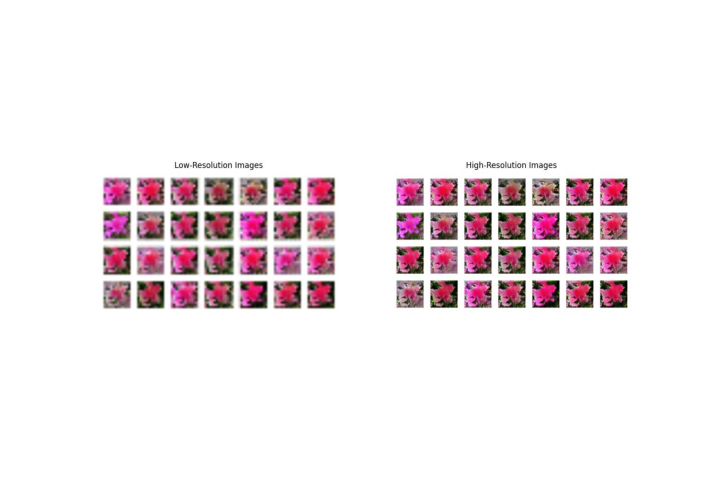

In [ ]:
image_path = 'Train_Examples_01.jpg'
image = mpimg.imread(image_path)

plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis('off')
plt.show()


Grid image saved to: /content/grid_image.png


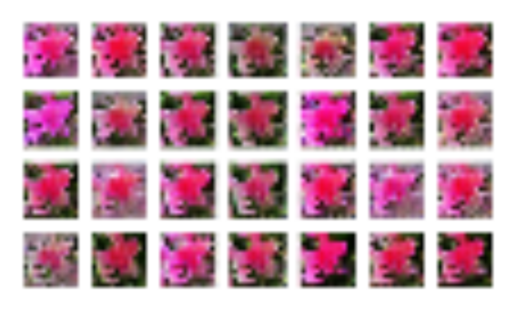

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Assuming you have already imported LR_imgs and set up the environment

# Create a grid from the LR_imgs
grid_image = np.transpose(torchvision.utils.make_grid(LR_imgs[:4], padding=1, normalize=True).cpu(), (1, 2, 0))

# Display the grid image using matplotlib
plt.imshow(grid_image)
plt.axis('off')  # Turn off axis for cleaner display

# Save the grid image to a file in Colab
save_path = '/content/grid_image.png'
plt.savefig(save_path, bbox_inches='tight', pad_inches=0)

# Optionally, show the saved image file path
print(f"Grid image saved to: {save_path}")


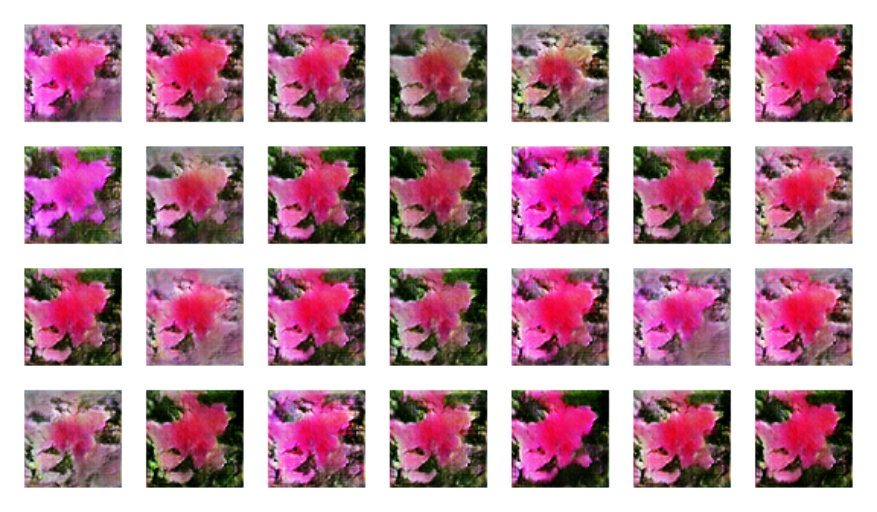

In [ ]:
import torchvision
import torch
import numpy as np
from PIL import Image
from IPython.display import display

# Assuming you have already defined the 'imgs' variable

# Create the image grid with padding
grid_images = torchvision.utils.make_grid(imgs[:4], padding=1, normalize=True).cpu()

# Transpose the grid to (height, width, channels) format for visualization
transposed_grid = np.transpose(grid_images, (1, 2, 0))

# Convert the tensor to a NumPy array
numpy_image = (transposed_grid * 255).numpy().astype(np.uint8)

# Convert the NumPy array to a PIL Image
image_to_display = Image.fromarray(numpy_image)

# Display the image directly
display(image_to_display)

# Save the image to a file (optional)
image_to_display.save('Train_Examples.png')


In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(original, compressed):
    if original is None or compressed is None:
        raise ValueError("Error: Image not read properly.")

    # Resize the compressed image to match the shape of the original image
    compressed = cv2.resize(compressed, (original.shape[1], original.shape[0]))

    # Convert the images to grayscale
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    compressed_gray = cv2.cvtColor(compressed, cv2.COLOR_BGR2GRAY)

    mse = np.mean((original_gray - compressed_gray) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                 # Therefore PSNR has no importance.
        return 100
    max_pixel = 254.0  # Change this value to 1.0 for images with pixel values in the range [0, 1]
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def main():
    original_path = "/content/grid_image.png"
    compressed_path = "/content/Train_Examples.png"

    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    compressed = cv2.imread(compressed_path, cv2.IMREAD_UNCHANGED)

    try:
        value = PSNR(original, compressed)
        print(f"PSNR value is {value} dB")
    except ValueError as e:
        print(e)

if __name__ == "__main__":
    main()
#PSNR value more than 30 considered to be good. It means the similerities between the input and the generated image.

PSNR value is 30.08210431178422 dB


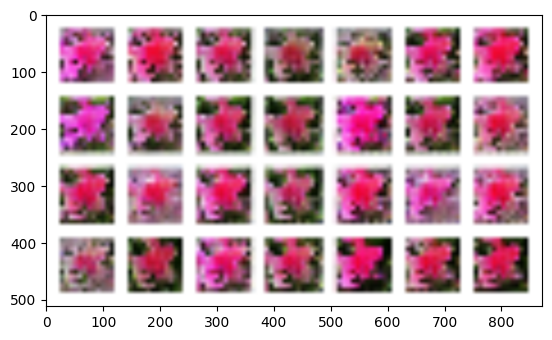

In [ ]:
#low res
plt.imshow(np.transpose(torchvision.utils.make_grid(LR_imgs[:4], padding=1, normalize=True).cpu(),(1,2,0)))

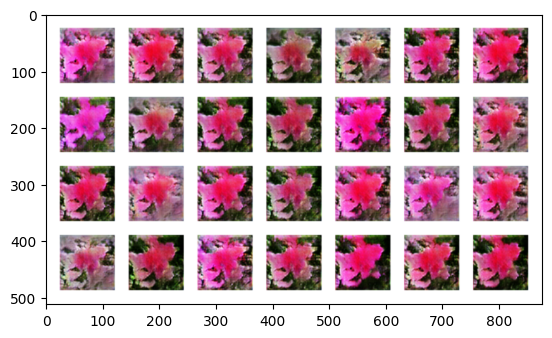

In [ ]:
#High res
plt.imshow(np.transpose(torchvision.utils.make_grid(imgs[:4], padding=1, normalize=True).cpu(),(1,2,0)))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch

# Assuming you have already defined the 'imgs' variable

# Create the image grid with padding
grid_images = torchvision.utils.make_grid(imgs[:4], padding=1, normalize=True).cpu()

# Transpose the grid to (height, width, channels) format for visualization
transposed_grid = np.transpose(grid_images, (1, 2, 0))

# Get the dimensions of the grid (including padding)
grid_height_with_padding, grid_width_with_padding, _ = transposed_grid.shape

# Calculate the actual grid size by subtracting padding
padding = 1
grid_height = grid_height_with_padding - 2 * padding
grid_width = grid_width_with_padding - 2 * padding

# Calculate the resolution of the image grid
resolution = grid_width * grid_height

print("Resolution of the image:", resolution)
#256*256 = 65536

Resolution of the image: 446250


In [ ]:
import torch, torchvision
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from einops import rearrange, repeat
from tqdm.notebook import tqdm
from functools import partial
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math, os, copy
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):

        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype, device=noise_level.device) / count
        encoding = noise_level.unsqueeze(1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat([torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding

class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(nn.Linear(in_channels, out_channels*(1+self.use_affine_level)))

    def forward(self, x, noise_embed):
        noise = self.noise_func(noise_embed).view(x.shape[0], -1, 1, 1)
        if self.use_affine_level:
            gamma, beta = noise.chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + noise
        return x

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))

class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)

# Linear Multi-head Self-attention
class SelfAtt(nn.Module):
    def __init__(self, channel_dim, num_heads, norm_groups=32):
        super(SelfAtt,self).__init__()
        self.groupnorm = nn.GroupNorm(norm_groups, channel_dim)
        self.num_heads = num_heads
        self.qkv = nn.Conv2d(channel_dim, channel_dim * 3, 1, bias=False)
        self.proj = nn.Conv2d(channel_dim, channel_dim, 1)

    def forward(self,x):
        b, c, h, w = x.size()
        x = self.groupnorm(x)
        qkv = rearrange(self.qkv(x), "b (qkv heads c) h w -> (qkv) b heads c (h w)", heads=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]

        keys = F.softmax(keys, dim=-1)
        att = torch.einsum('bhdn,bhen->bhde', keys, values)
        out = torch.einsum('bhde,bhdn->bhen', att, queries)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.num_heads, h=h, w=w)

        return self.proj(out)


class ResBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0,
                    num_heads=1, use_affine_level=False, norm_groups=32, att=True):
        super().__init__()
        self.noise_func = FeatureWiseAffine(noise_level_emb_dim, dim_out, use_affine_level)
        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
        self.att = att
        self.attn = SelfAtt(dim_out, num_heads=num_heads, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        y = self.block1(x)
        y = self.noise_func(y, time_emb)
        y = self.block2(y)
        x = y + self.res_conv(x)
        if self.att:
            x = self.attn(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channel=6, out_channel=3, inner_channel=32, norm_groups=32,
        channel_mults=[1, 2, 4, 8, 8], res_blocks=3, dropout=0, img_size=256):
        super().__init__()

        noise_level_channel = inner_channel
        self.noise_level_mlp = nn.Sequential(
            PositionalEncoding(inner_channel),
            nn.Linear(inner_channel, inner_channel * 4),
            Swish(),
            nn.Linear(inner_channel * 4, inner_channel)
        )

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = img_size

        # Downsampling stage of U-net
        downs = [nn.Conv2d(in_channel, inner_channel, kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResBlock(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel,
                    norm_groups=norm_groups, dropout=dropout))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResBlock(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel,
                            norm_groups=norm_groups, dropout=dropout),
            ResBlock(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel,
                        norm_groups=norm_groups, dropout=dropout, att=False)
        ])

        # Upsampling stage of U-net
        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResBlock(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel,
                    norm_groups=norm_groups, dropout=dropout))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, out_channel, groups=norm_groups)

    def forward(self, x, noise_level):
        # Embedding of time step with noise coefficient alpha
        t = self.noise_level_mlp(noise_level)

        feats = []
        for layer in self.downs:
            if isinstance(layer, ResBlock):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            x = layer(x, t)

        for layer in self.ups:
            if isinstance(layer, ResBlock):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)


"""
    Define Diffusion process framework to train desired model:
    Forward Diffusion process:
        Given original image x_0, apply Gaussian noise ε_t for each time step t
        After proper length of time step, image x_T reachs to pure Gaussian noise
    Objective of model f :
        model f is trained to predict actual added noise ε_t for each time step t
"""

class Diffusion(nn.Module):
    def __init__(self, model, device, img_size, LR_size, channels=3):
        super().__init__()
        self.channels = channels
        self.model = model.to(device)
        self.img_size = img_size
        self.LR_size = LR_size
        self.device = device

    def set_loss(self, loss_type):
        if loss_type == 'l1':
            self.loss_func = nn.L1Loss(reduction='sum')
        elif loss_type == 'l2':
            self.loss_func = nn.MSELoss(reduction='sum')
        else:
            raise NotImplementedError()

    def make_beta_schedule(self, schedule, n_timestep, linear_start=1e-4, linear_end=2e-2):
        if schedule == 'linear':
            betas = np.linspace(linear_start, linear_end, n_timestep, dtype=np.float64)
        elif schedule == 'warmup':
            warmup_frac=0.1
            betas = linear_end * np.ones(n_timestep, dtype=np.float64)
            warmup_time = int(n_timestep * warmup_frac)
            betas[:warmup_time] = np.linspace(linear_start, linear_end, warmup_time, dtype=np.float64)
        elif schedule == "cosine":
            cosine_s = 8e-3
            timesteps = torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep + cosine_s
            alphas = timesteps / (1 + cosine_s) * math.pi / 2
            alphas = torch.cos(alphas).pow(2)
            alphas = alphas / alphas[0]
            betas = 1 - alphas[1:] / alphas[:-1]
            betas = betas.clamp(max=0.999)
        else:
            raise NotImplementedError(schedule)
        return betas

    def set_new_noise_schedule(self, schedule_opt):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=self.device)

        betas = self.make_beta_schedule(
            schedule=schedule_opt['schedule'],
            n_timestep=schedule_opt['n_timestep'],
            linear_start=schedule_opt['linear_start'],
            linear_end=schedule_opt['linear_end'])
        betas = betas.detach().cpu().numpy() if isinstance(betas, torch.Tensor) else betas
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
        self.sqrt_alphas_cumprod_prev = np.sqrt(np.append(1., alphas_cumprod))

        self.num_timesteps = int(len(betas))
        # Coefficient for forward diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(alphas_cumprod_prev))
        self.register_buffer('pred_coef1', to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('pred_coef2', to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # Coefficient for reverse diffusion posterior q(x_{t-1} | x_t, x_0)
        variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        self.register_buffer('variance', to_torch(variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch((1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    # Predict desired image x_0 from x_t with noise z_t -> Output is predicted x_0
    def predict_start(self, x_t, t, noise):
        return self.pred_coef1[t] * x_t - self.pred_coef2[t] * noise

    # Compute mean and log variance of posterior(reverse diffusion process) distribution
    def q_posterior(self, x_start, x_t, t):
        posterior_mean = self.posterior_mean_coef1[t] * x_start + self.posterior_mean_coef2[t] * x_t
        posterior_log_variance_clipped = self.posterior_log_variance_clipped[t]
        return posterior_mean, posterior_log_variance_clipped

    # Note that posterior q for reverse diffusion process is conditioned Gaussian distribution q(x_{t-1}|x_t, x_0)
    # Thus to compute desired posterior q, we need original image x_0 in ideal,
    # but it's impossible for actual training procedure -> Thus we reconstruct desired x_0 and use this for posterior
    def p_mean_variance(self, x, t, clip_denoised: bool, condition_x=None):
        batch_size = x.shape[0]
        noise_level = torch.FloatTensor([self.sqrt_alphas_cumprod_prev[t+1]]).repeat(batch_size, 1).to(x.device)
        x_recon = self.predict_start(x, t, noise=self.model(torch.cat([condition_x, x], dim=1), noise_level))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        mean, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return mean, posterior_log_variance

    # Progress single step of reverse diffusion process
    # Given mean and log variance of posterior, sample reverse diffusion result from the posterior
    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, condition_x=None):
        mean, log_variance = self.p_mean_variance(x=x, t=t, clip_denoised=clip_denoised, condition_x=condition_x)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        return mean + noise * (0.5 * log_variance).exp()

    # Progress whole reverse diffusion process
    @torch.no_grad()
    def super_resolution(self, x_in):
        img = torch.rand_like(x_in, device=x_in.device)
        for i in reversed(range(0, self.num_timesteps)):
            img = self.p_sample(img, i, condition_x=x_in)
        return img

    # Compute loss to train the model
    def p_losses(self, x_in):
        x_start = x_in
        lr_imgs = transforms.Resize(self.img_size)(transforms.Resize(self.LR_size)(x_in))
        b, c, h, w = x_start.shape
        t = np.random.randint(1, self.num_timesteps + 1)
        sqrt_alpha = torch.FloatTensor(
            np.random.uniform(self.sqrt_alphas_cumprod_prev[t-1], self.sqrt_alphas_cumprod_prev[t], size=b)
        ).to(x_start.device)
        sqrt_alpha = sqrt_alpha.view(-1, 1, 1, 1)

        noise = torch.randn_like(x_start).to(x_start.device)
        # Perturbed image obtained by forward diffusion process at random time step t
        x_noisy = sqrt_alpha * x_start + (1 - sqrt_alpha**2).sqrt() * noise
        # The model predict actual noise added at time step t
        pred_noise = self.model(torch.cat([lr_imgs, x_noisy], dim=1), noise_level=sqrt_alpha)

        return self.loss_func(noise, pred_noise)

    def forward(self, x, *args, **kwargs):
        return self.p_losses(x, *args, **kwargs)


# Class to train & test desired model
class SR3():
    def __init__(self, device, img_size, LR_size, loss_type, dataloader, testloader,
                    schedule_opt, save_path, load_path=None, load=False,
                    in_channel=6, out_channel=3, inner_channel=32, norm_groups=8,
                    channel_mults=(1, 2, 4, 8, 8), res_blocks=3, dropout=0, lr=1e-5, distributed=False):
        super(SR3, self).__init__()
        self.dataloader = dataloader
        self.testloader = testloader
        self.device = device
        self.save_path = save_path
        self.img_size = img_size
        self.LR_size = LR_size

        model = UNet(in_channel, out_channel, inner_channel, norm_groups, channel_mults, res_blocks, dropout, img_size)
        self.sr3 = Diffusion(model, device, img_size, LR_size, out_channel)

        # Apply weight initialization & set loss & set noise schedule
        self.sr3.apply(self.weights_init_orthogonal)
        self.sr3.set_loss(loss_type)
        self.sr3.set_new_noise_schedule(schedule_opt)

        if distributed:
            assert torch.cuda.is_available()
            self.sr3 = nn.DataParallel(self.sr3)

        self.optimizer = torch.optim.Adam(self.sr3.parameters(), lr=lr)

        params = sum(p.numel() for p in self.sr3.parameters())
        print(f"Number of model parameters : {params}")

        if load:
            self.load(load_path)

    def weights_init_orthogonal(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            init.orthogonal_(m.weight.data, gain=1)
            if m.bias is not None:
                m.bias.data.zero_()
        elif classname.find('Linear') != -1:
            init.orthogonal_(m.weight.data, gain=1)
            if m.bias is not None:
                m.bias.data.zero_()
        elif classname.find('BatchNorm2d') != -1:
            init.constant_(m.weight.data, 1.0)
            init.constant_(m.bias.data, 0.0)

    def train(self, epoch, verbose):
        fixed_imgs = copy.deepcopy(next(iter(self.testloader)))
        fixed_imgs = fixed_imgs[0].to(self.device)
        # Transform to low-resolution images
        fixed_imgs = transforms.Resize(self.img_size)(transforms.Resize(self.LR_size)(fixed_imgs))

        for i in tqdm(range(epoch)):
            train_loss = 0
            for _, imgs in enumerate(self.dataloader):
                # Initial imgs are high-resolution
                imgs = imgs[0].to(self.device)
                b, c, h, w = imgs.shape

                self.optimizer.zero_grad()
                loss = self.sr3(imgs)
                loss = loss.sum() / int(b*c*h*w)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * b

            if (i+1) % verbose == 0:
                self.sr3.eval()
                test_imgs = next(iter(self.testloader))
                test_imgs = test_imgs[0].to(self.device)
                b, c, h, w = test_imgs.shape

                with torch.no_grad():
                    val_loss = self.sr3(test_imgs)
                    val_loss = val_loss.sum() / int(b*c*h*w)
                self.sr3.train()

                train_loss = train_loss / len(self.dataloader)
                print(f'Epoch: {i+1} / loss:{train_loss:.3f} / val_loss:{val_loss.item():.3f}')

                # Save example of test images to check training
                plt.figure(figsize=(15,10))
                plt.subplot(1,2,1)
                plt.axis("off")
                plt.title("Low-Resolution Inputs")
                plt.imshow(np.transpose(torchvision.utils.make_grid(fixed_imgs,
                                                                    nrow=2, padding=1, normalize=True).cpu(),(1,2,0)))

                plt.subplot(1,2,2)
                plt.axis("off")
                plt.title("Super-Resolution Results")
                plt.imshow(np.transpose(torchvision.utils.make_grid(self.test(fixed_imgs).detach().cpu(),
                                                                    nrow=2, padding=1, normalize=True),(1,2,0)))
                plt.savefig('SuperResolution_Result.jpg')
                plt.close()

                # Save model weight
                self.save(self.save_path)

    # Modify the test method to use the test_image
    def test(self, test_image):
      test_image_lr = transforms.Resize(self.LR_size)(test_image)
      self.sr3.eval()
      with torch.no_grad():
          if isinstance(self.sr3, nn.DataParallel):
              result_SR = self.sr3.module.super_resolution(test_image_lr)
          else:
              result_SR = self.sr3.super_resolution(test_image_lr)
      self.sr3.train()

      # Convert the images back to the original range
      test_image_lr = (test_image_lr.squeeze().permute(1, 2, 0) + 1) / 2.0
      result_SR = (result_SR.squeeze().permute(1, 2, 0) + 1) / 2.0

      # Plot the images side by side
      fig, axes = plt.subplots(1, 2, figsize=(10, 5))
      axes[0].axis("off")
      axes[0].set_title("Low-Resolution Image")
      axes[0].imshow(test_image_lr)

      axes[1].axis("off")
      axes[1].set_title("Super-Resolved Image")
      axes[1].imshow(result_SR)

      plt.show()

    def save(self, save_path):
        network = self.sr3
        if isinstance(self.sr3, nn.DataParallel):
            network = network.module
        state_dict = network.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save(state_dict, save_path)

    def load(self, load_path):
        network = self.sr3
        if isinstance(self.sr3, nn.DataParallel):
            network = network.module
        network.load_state_dict(torch.load(load_path))
        print("Model loaded successfully")


if __name__ == "__main__":
    batch_size = 1
    LR_size = 32
    img_size = 256
    root = '/content/drive/MyDrive/Thesis/thumbnails128x128-20230716T091018Z-002/thumbnails128x128'
    testroot = '/content/drive/MyDrive/Thesis/celeba_hq/train'

    transforms_ = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor(),
                                        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    dataloader = DataLoader(torchvision.datasets.ImageFolder(root, transform=transforms_),
                            batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    # Remove the testloader creation code block

    # Load a single test image
    test_image_path = '/content/drive/MyDrive/Thesis/102flowers/output_64_character_extended/train-2.png'
    test_image = Image.open(test_image_path).convert('RGB')

    # Transform the test image
    test_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    test_image = test_transform(test_image).unsqueeze(0)

    # Save test image
    plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.title("Test Image")
    plt.imshow(np.transpose(torchvision.utils.make_grid(test_image, padding=1, normalize=True).cpu(), (1, 2, 0)))
    plt.savefig('Test_Image.jpg')
    plt.close()
    print("Test image was saved")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test image was saved
